## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import demoji

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../common')) # add path to common functions

In [3]:
from preprocess import getdfs

train_df, val_df = getdfs()

## Emoji to Text to BERT Embedding

In [4]:
for i in range(13) :
    train_df[f'c_{i+1}_text'] = train_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)
    val_df[f'c_{i+1}_text'] = val_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
def text2embed(text) :
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1)

    return sentence_embedding.numpy().reshape(-1)

In [7]:
texts = []
for i in range(13) :
    for text in train_df[f'c_{i+1}_text'] :
        texts.append(text)
texts = list(set(texts))

In [8]:
dict_text2bed = {f'{text}' : text2embed(text) for text in texts}

In [9]:
def embed_df(df : pd.DataFrame, embedding_dim : int = 768, num_columns: int = 13)-> pd.DataFrame :

    # Initialize a list to store rows of combined embeddings
    combined_embeddings = []

    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        row_embeddings = []
        
        # Iterate over the 13 columns and get the embedding for each
        for i in range(num_columns):
            column_text = row[f'c_{i+1}_text']
            
            # If the text is not empty, fetch its embedding, else use a zero vector
            if column_text != '':
                embedding = dict_text2bed.get(column_text, np.zeros(embedding_dim))
            else:
                embedding = np.zeros(embedding_dim)
            
            # Append the embedding to the row list
            row_embeddings.append(embedding)
        
        # Concatenate the embeddings for the row
        combined_embeddings.append(np.hstack(row_embeddings))

    # Convert the list of rows into a NumPy array
    X = np.vstack(combined_embeddings)
    
    return X



In [10]:
X_train = embed_df(train_df)
y_train = train_df['label']

X_val = embed_df(val_df)
y_val = val_df['label']

## Models and Evaluation

In [15]:
from models import predict_xgboost, predict_mlp, predict_logistic_regression, predict_random_forest

In [12]:
y_pred = predict_xgboost(X_train, y_train, X_val)

[02:52:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



              precision    recall  f1-score   support

     Class 0       0.83      0.73      0.78       252
     Class 1       0.75      0.84      0.79       237

    accuracy                           0.79       489
   macro avg       0.79      0.79      0.79       489
weighted avg       0.79      0.79      0.79       489



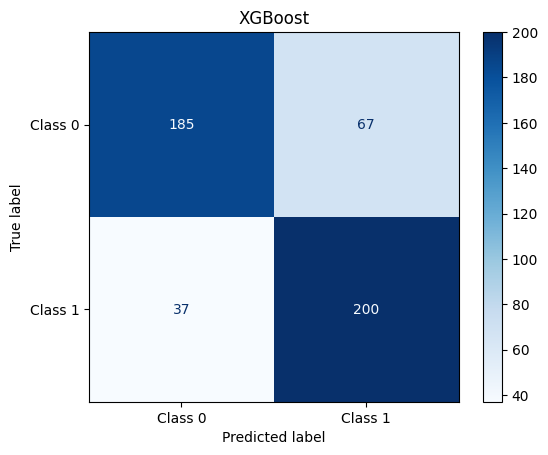

Accuracy is 0.787321063394683


In [14]:
from evaluate import evaluate_predictions

evaluate_predictions(y_val, y_pred, 'XGBoost')

              precision    recall  f1-score   support

     Class 0       0.76      0.71      0.73       252
     Class 1       0.71      0.77      0.74       237

    accuracy                           0.74       489
   macro avg       0.74      0.74      0.74       489
weighted avg       0.74      0.74      0.74       489



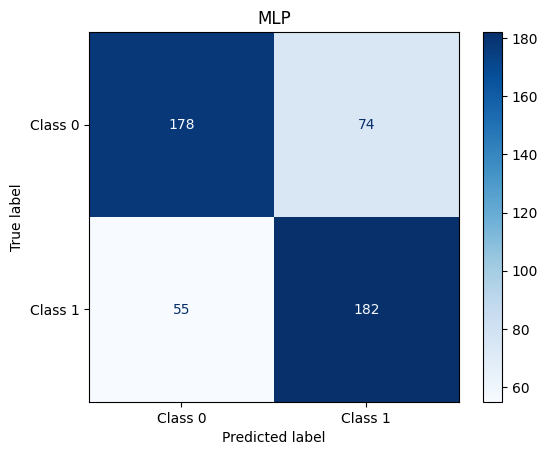

Accuracy is 0.7361963190184049


In [16]:
y_pred = predict_mlp(X_train, y_train, X_val)

evaluate_predictions(y_val, y_pred, 'MLP')

              precision    recall  f1-score   support

     Class 0       0.86      0.78      0.82       252
     Class 1       0.79      0.87      0.83       237

    accuracy                           0.82       489
   macro avg       0.83      0.83      0.82       489
weighted avg       0.83      0.82      0.82       489



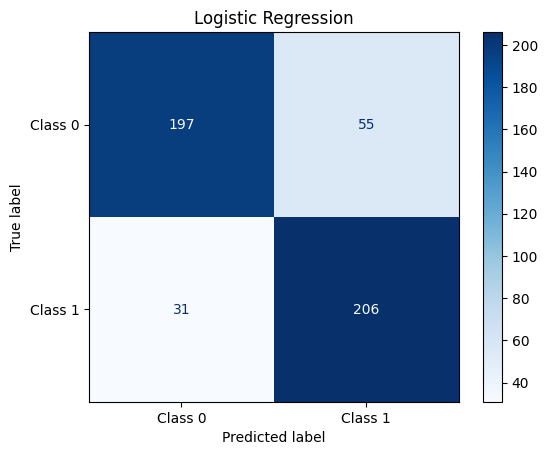

Accuracy is 0.8241308793456033


In [17]:
y_pred = predict_logistic_regression(X_train, y_train, X_val)
evaluate_predictions(y_val, y_pred, 'Logistic Regression')

              precision    recall  f1-score   support

     Class 0       0.73      0.77      0.75       252
     Class 1       0.74      0.70      0.72       237

    accuracy                           0.74       489
   macro avg       0.74      0.74      0.74       489
weighted avg       0.74      0.74      0.74       489



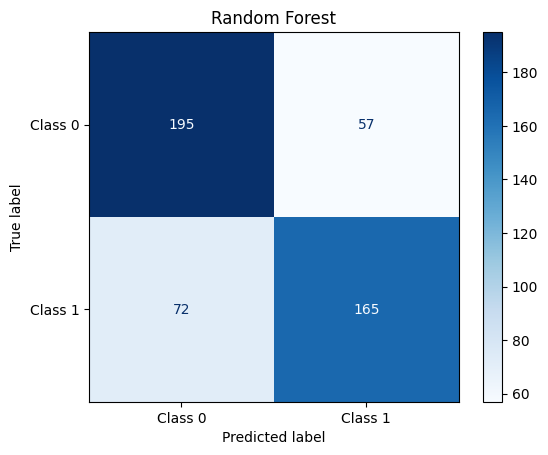

Accuracy is 0.7361963190184049


In [18]:
y_pred = predict_random_forest(X_train, y_train, X_val)
evaluate_predictions(y_val, y_pred, 'Random Forest')